# 0.0 Import modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from itertools import product as prod
from collections import defaultdict

from scipy import stats as ss

## 0.1 Problema

Uma seguradora de planos de saúde pretende passar a vender, também, seguros de automóveis.

A seguradora realizou pesquisa com cerca de 380.000 clientes para saber se teriam interesse, ou não, em contrtar o novo seguro. Todos os clientes responderam.

A seguradora selecionou cerca de 127.000 potenciais clientes para participar de uma campanha. Este grupo receberá a oferta de adesão ao seguro de automóvel via ligação telefônica.

**Problema**: o time de vendas tem condições de ligar para, somente, 20.000 pessoas. Como selecionar, dentre os potenciais clientes, aqueles que tem maior probabilidade de adquirir o seguro?

O *relatório* deve responder às seguintes questões:

1. Fornecer *insights* sobre os atributos mais relevantes de clientes interessados em adquirir o seguro.

2. Qual porcentagem dos potenciais clientes interessados o time de vendas vai conseguir aontatar fazendo 20.000 ligações?

3. Se o time de vendas fizer 40.000 ligações, qual será a porcentagem de clientes interessados contatada?

4. Quantas ligações o time de vendas precisariaria fazer para contatar 80% dos potenciais clientes interessados?

## 0.2 Load data

The file "table.csv" contains only the train data. The test data is in a separate file, "test.csv", which was downloaded via Kaggle's API.

In [2]:
df_train_raw = pd.read_csv('table.csv')

In [3]:
df_train_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


A variável *response* é a variável resposta (target). As outras variáveis são as características (features).

## 0.3 Plano de solução

Após a limpeza dos dados, checarei algumas hipóteses (lista logo abaixo) que gerarão insights sobre a revelância dos atributos para o interesse dos clientes em adquirir o seguro de automóveis.

Utilizarei algum método de redução de dimensionalidade para encontrar quais atributos mais contribuem para a variância (Boruta).

Identificados os atributos, resta resolver um problema de clusterização: dividir os dados de teste em "interesse" e "não interesse", de acordo com os atributos daqueles dados. *Os dados de teste não tem a variável target, pois o time de vendas ainda não contatou aqueles potenciais clientes*. MiniBatchKMeans?

Contar os potenciais clientes classificados como "interesse" e responder às demais perguntas do relatório.

# 1.0 Análise descritiva dos dados

In [4]:
df1 = df_train_raw.copy()

## 1.1 Check and fill NA

In [5]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.2 Data types

In [6]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

The values in "driving_license" and "previously_insured" will be rewritten. In both cases, 1:'yes', 0:'no'.

The types of "id", "region_code" and "policy_sales_channel" will also be redefined. It might be harder to locate customer id '10' than customer id 10, but keeping these attributes as numerical might give rise to confusion when the statistical description of data is performed below.

In [7]:
df1.replace({'driving_license': {0:'no', 1:'yes'}, 'previously_insured': {0:'no', 1:'yes'}}, inplace=True)

df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,yes,> 2 Years,Yes,no,40454.0,217,1
1,2,Male,76,3.0,26.0,yes,1-2 Year,No,no,33536.0,183,0
2,3,Male,47,28.0,26.0,yes,> 2 Years,Yes,no,38294.0,27,1
3,4,Male,21,11.0,152.0,yes,< 1 Year,No,yes,28619.0,203,0
4,5,Female,29,41.0,152.0,yes,< 1 Year,No,yes,27496.0,39,0


In [8]:
df1['id'] = df1['id'].astype(object)
df1['region_code'] = df1['region_code'].astype(int).astype(object)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int).astype(object)

In [9]:
df1.dtypes

id                       object
gender                   object
age                       int64
region_code              object
policy_sales_channel     object
driving_license          object
vehicle_age              object
vehicle_damage           object
previously_insured       object
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

I don't know if it's better to separate the feature and target variables at this point. If I don't, I might alter the target values (by some mean, for example). Whereas if I do, I might, in the feature engineering process, change the order of the samples and create a mess! 

## 1.3 Descriptive Statistics

In [10]:
df2 = df1.copy()

In [11]:
num_attr = df2.select_dtypes(include=('int64', 'float64'))
cat_attr = df2.select_dtypes(include=['object'])

### 1.3.1 Numerical attributes

In [12]:
num_desc = num_attr.describe()
num_range = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min()), columns=['range']).T
num_skew = pd.DataFrame(num_attr.skew(), columns=['skew']).T
num_kurt = pd.DataFrame(num_attr.kurt(), columns=['kurtosis']).T

num_stat = pd.concat([num_desc, num_range, num_skew, num_kurt]).T.drop(columns=['count'])
num_stat

,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
age,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,65.0,0.672539,-0.565655
annual_premium,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,537535.0,1.766087,34.004569
vintage,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,289.0,0.003030,-1.200688
response,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,1.0,2.301906,3.298788


Most customers answered that they are not interested in a car insurance. Only 12% answered 'yes' on the survey.

### 1.3.2 Categorical attributes

Count number of categories in each feature

In [13]:
cat_attr.apply(lambda x: x.unique().shape[0])

id                      381109
gender                       2
region_code                 53
policy_sales_channel       155
driving_license              2
vehicle_age                  3
vehicle_damage               2
previously_insured           2
dtype: int64

I will drop 'id' and 'policy_sales_channel' from the descriptive statistics analysis

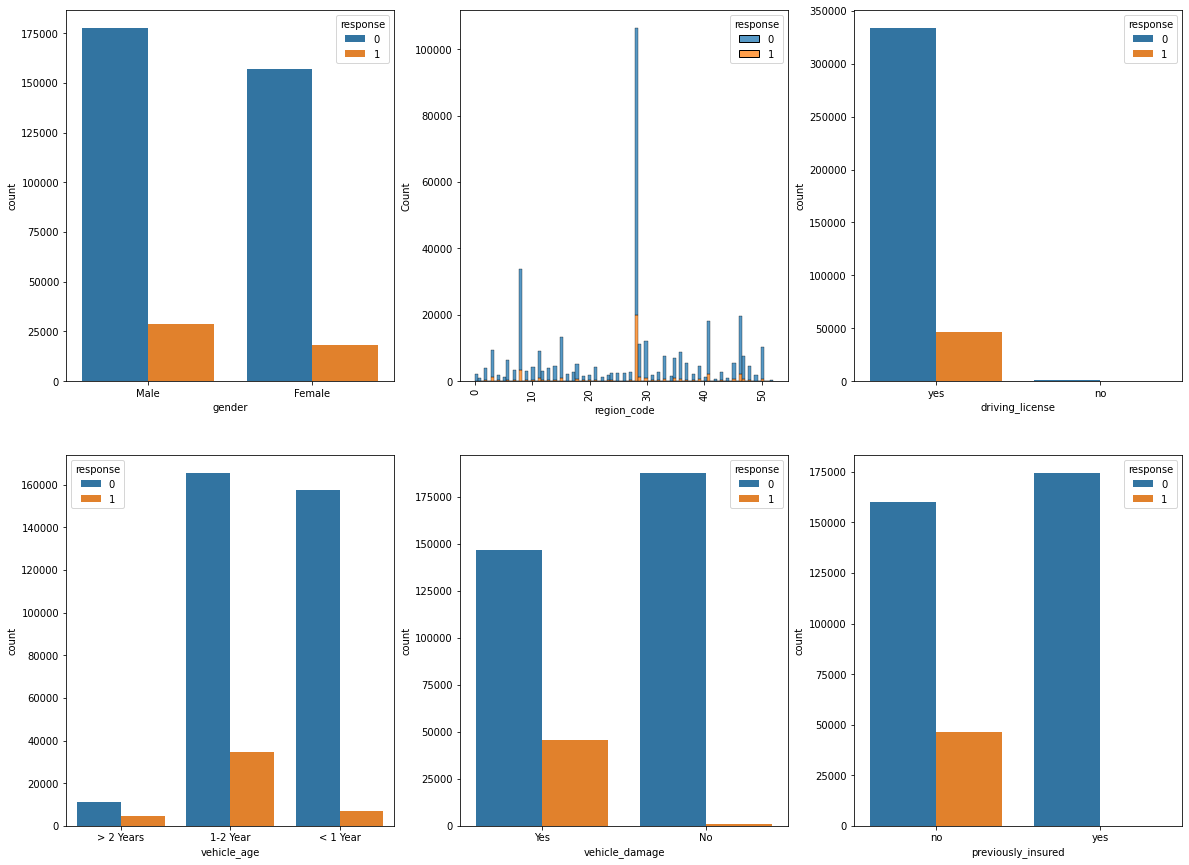

In [14]:
plt.figure(figsize=(20, 15))


plt.subplot(2, 3, 1)
sns.countplot(data=df2, x='gender', hue='response');#, multiple='stack');

plt.subplot(2, 3, 2)
sns.histplot(data = df2, x='region_code', hue='response', multiple='stack');
plt.xticks(rotation=90)

plt.subplot(2, 3, 3)
sns.countplot(data=df2, x='driving_license', hue='response');#, multiple='stack');

plt.subplot(2, 3, 4)
sns.countplot(data=df2, x='vehicle_age', hue='response');#, multiple='stack');

plt.subplot(2, 3, 5)
sns.countplot(data=df2, x='vehicle_damage', hue='response');#, multiple='stack');

plt.subplot(2, 3, 6)
sns.countplot(data=df2, x='previously_insured', hue='response');#, multiple='stack');

# 2.0 Feature Engineering

In [15]:
df2 = df1.copy()

## 2.1 Hipóteses

**1** Clientes sem licença tem menos probabilidade de adquirir seguro de automóvel.

**2** Clientes menores de idade tem menos probabilidade de adquirir seguro de automóvel.

**3** Clientes não-idosos tem maior probabilidade de adquirir seguro de automóvel.

**4** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**5** Clientes com carros mais antigos tem menor probabilidade de adquirir seguro de automóvel.

**6** Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

**7** Clientes há mais tempo tem maior probabilidade de adquirir seguro de automóvel.

**8** Clientes que pagam mais pelo seguro saúde tem maior probabilidade de adquirir seguro de automóvel.

## 2.2 Hipóteses que serão testadas:

**1** Clientes sem licença tem meno probabilidade de adquirir seguro de automóvel.

<s>**2** Clientes menores de idade tem menos probabilidade de adquirir seguro de automóvel.</s>
Todos os clientes entrevistados são maiores de idade.

**3** Clientes não-idosos tem maior probabilidade de adquirir seguro de automóvel.

**4** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**5** Clientes com carros mais antigos tem menor probabilidade de adquirir seguro de automóvel.

**6** Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

**7** Clientes há mais tempo tem maior probabilidade de adquirir seguro de automóvel.

**8** Clientes que pagam mais pelo seguro saúde tem maior probabilidade de adquirir seguro de automóvel.

## 2.3 Feature Engineering

# 3.0 Filtragem das variáveis

In [16]:
df3 = df2.copy()

In [17]:
df3 = df3.drop(columns=['policy_sales_channel'])

# 4.0 Análise Exploratória dos Dados

In [18]:
df4 = df3.copy()

In [19]:
num_attr = df4.select_dtypes(include=('int64', 'float64'))
cat_attr = df4.select_dtypes(include=['object'])

## 4.1 Análise Univariada

### 4.1.1 Response Variable

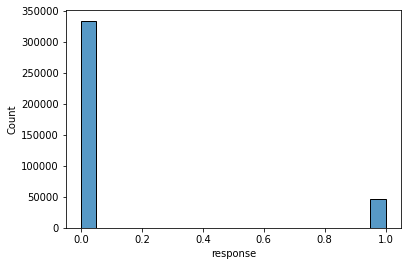

In [20]:
sns.histplot(data = df4, x='response');

### 4.1.2 Numerical Variables

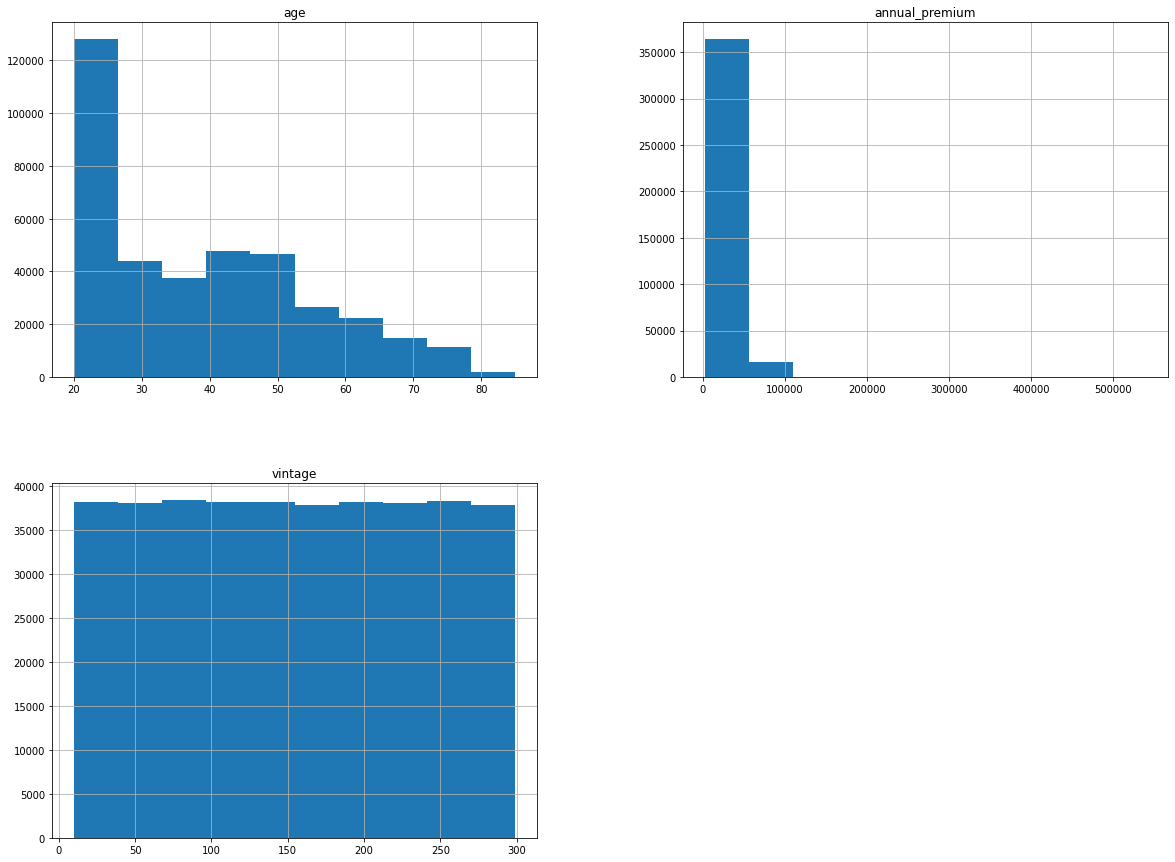

In [21]:
num_attr.drop(columns=['response']).hist(figsize=(20, 15));

### 4.1.3 Categorical Variables

In [22]:
cat_attr.drop(columns=['id']).head()

,gender,region_code,driving_license,vehicle_age,vehicle_damage,previously_insured
0,Male,28,yes,> 2 Years,Yes,no
1,Male,3,yes,1-2 Year,No,no
2,Male,28,yes,> 2 Years,Yes,no
3,Male,11,yes,< 1 Year,No,yes
4,Female,41,yes,< 1 Year,No,yes


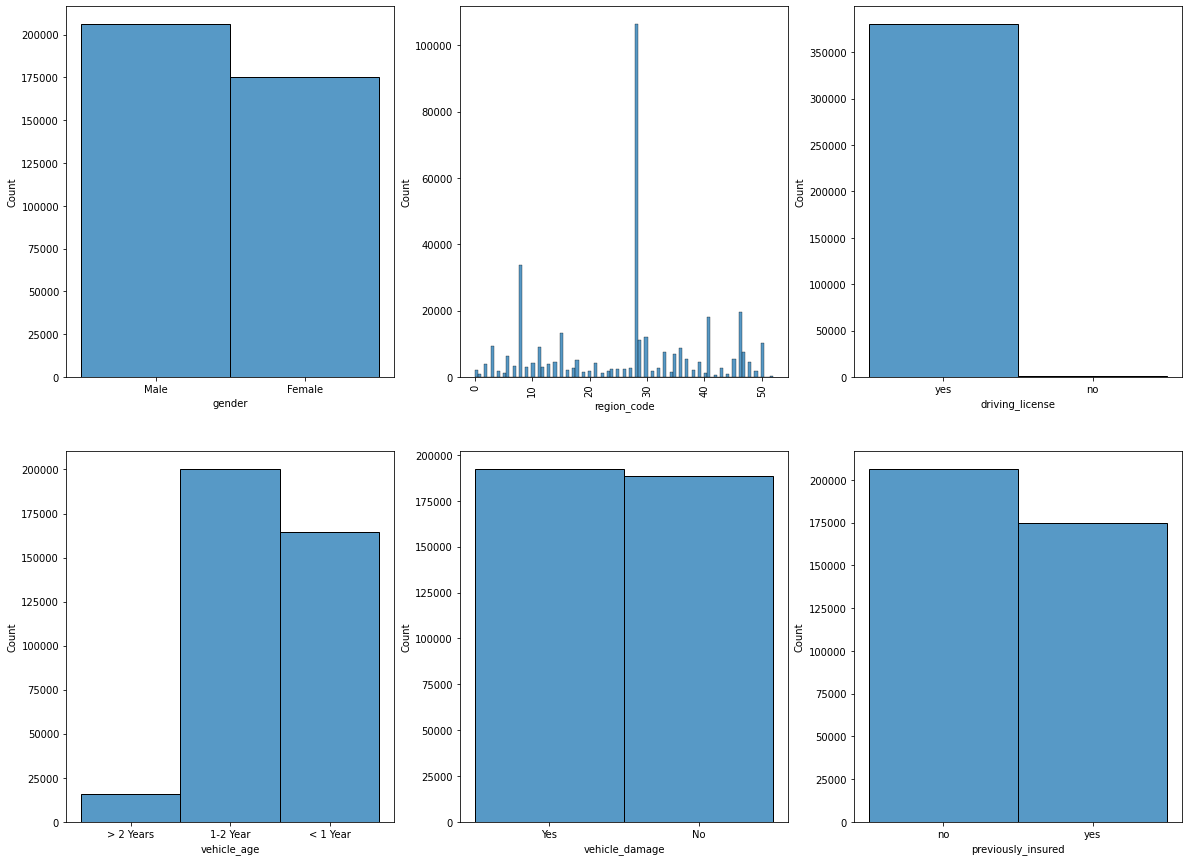

In [23]:
plt.figure(figsize=(20, 15))


plt.subplot(2, 3, 1)
sns.histplot(data=cat_attr, x='gender');

plt.subplot(2, 3, 2)
sns.histplot(data = cat_attr, x='region_code');
plt.xticks(rotation=90)

plt.subplot(2, 3, 3)
sns.histplot(data=cat_attr, x='driving_license');

plt.subplot(2, 3, 4)
sns.histplot(data=cat_attr, x='vehicle_age');

plt.subplot(2, 3, 5)
sns.histplot(data=cat_attr, x='vehicle_damage');

plt.subplot(2, 3, 6)
sns.histplot(data=cat_attr, x='previously_insured');

## 4.2 Análise Bivariada

In [24]:
df4_1 = df4[df4['response'] == 1]

**H1** Clientes sem licença tem menor probabilidade de adquirir seguro de automóvel.

**Verdadeira**

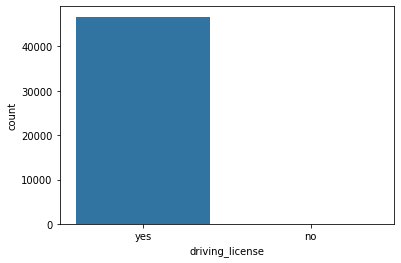

In [25]:
sns.countplot(data=df4_1, x='driving_license');

**H2** Clientes não-idosos tem maior probabilidade de adquirir seguro de automóvel.

**Verdadeira**

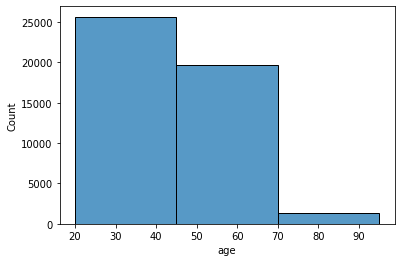

In [26]:
sns.histplot(data=df4_1, x='age', binwidth=25);

**H3** Clientes mulheres tem maior probabilidade de adquirir seguro de automóvel.

**Falsa** Clientes homens tem maior probabilidade de adquirir seguro de automóvel.

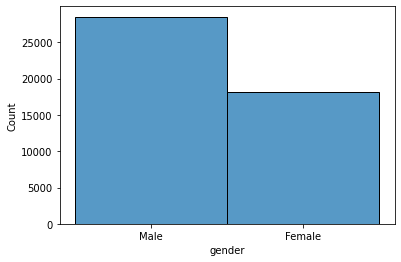

In [27]:
sns.histplot(data=df4_1, x='gender');

Para testar esta hipótese, precisarei de duas variáveis para calcular as médias das respostas para homens e mulheres.

In [28]:
male_mean = df4[(df4['gender'] == 'Male') & (df4['response'] == 1)].size/df4[df4['gender'] == 'Male'].size
male_mean = male_mean.round(2)
male_mean

0.14

In [29]:
female_mean = df4[(df4['gender'] == 'Female') & (df4['response'] == 1)].size/df4[df4['gender'] == 'Female'].size
female_mean = female_mean.round(2)
female_mean

0.1

**H4** Clientes com carros mais antigos tem menor probabilidade de adquirir seguro de automóvel.

**Verdadeira**

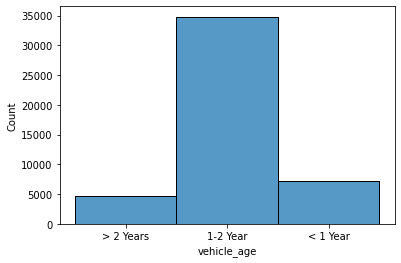

In [30]:
sns.histplot(data=df4_1, x='vehicle_age');

**H5** Clientes que já tiveram seu veículo danificado tem maior probabilidade de adquirir seguro de automóvel.

**Verdadeira**

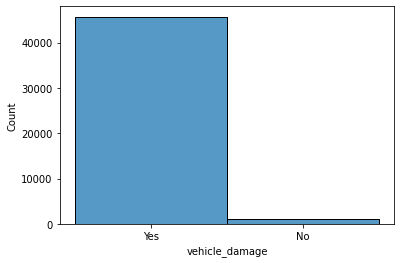

In [31]:
sns.histplot(data=df4_1, x='vehicle_damage');

**H6** Clientes há mais tempo tem maior probabilidade de adquirir seguro de automóvel.

**Falsa** Não há correlação notável entre "vintage" e o seguro de automóvel.

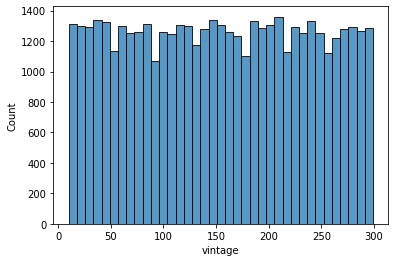

In [32]:
sns.histplot(data=df4_1, x='vintage');

**H7** Clientes que pagam mais pelo seguro saúde tem maior probabilidade de adquirir seguro de automóvel.

**Falsa**

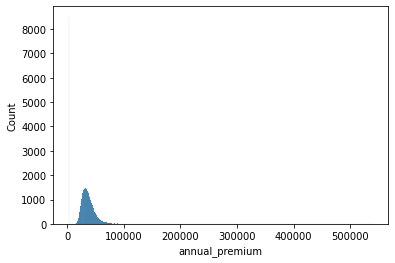

In [33]:
sns.histplot(data=df4_1, x='annual_premium');

## 4.3 Análise Multivariada

### 4.3.1 Variáveis Numéricas

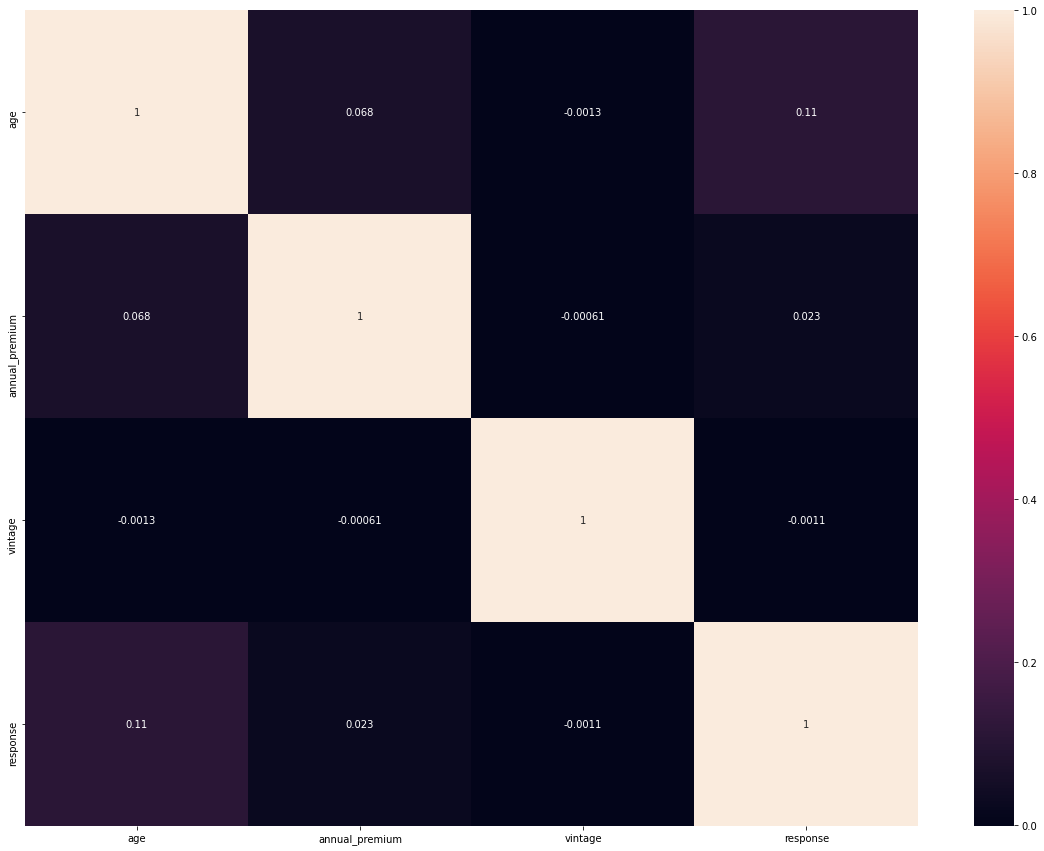

In [34]:
correl = num_attr.corr(method='pearson')
plt.figure(figsize=(20,15))
sns.heatmap(correl, annot=True);

There is little correlation among the numerical variables

### 4.3.2 Variáveis categóricas

In [35]:
indexes = cat_attr.columns

#for scalability, I will create a function that returns Cramér's V correlation:

def cat_corr(x, y):
    '''Cross frequencies'''
    cont_mat = pd.crosstab(x, y).to_numpy()
    
    n = cont_mat.sum()
    r, k = cont_mat.shape
    
    '''chi square statistics'''
    chi2 = ss.chi2_contingency(cont_mat)[0]
    
    '''Corrected variables to compensate for bias:'''
    chi2corr = max(0, (chi2/n) - (k - 1)*(r - 1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    
    '''Cramérs V correlation'''''
    cramer_v = np.sqrt((chi2corr)/(min(k_corr-1, r_corr-1)))
    return cramer_v


d = defaultdict(list)
#d = {}
for x, y in prod(indexes, repeat=2):
    d[x].append(cat_corr(cat_attr[x],cat_attr[y]))

a = pd.DataFrame(d, index=indexes)

plt.figure(figsize=(15,10))
sns.heatmap(a, annot=True);

ValueError: Unstacked DataFrame is too big, causing int32 overflow